In [50]:
%cd /data/gunsbrother/prjs/ltvu/ours
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import cv2
from PIL import Image
from sentence_transformers import SentenceTransformer, util

import lightning as L

/data/gunsbrother/prjs/ltvu/ours


In [20]:
p_json = Path('/data/gunsbrother/prjs/ltvu/llms/GroundVQA/analysis/VLG_OpenQA.json')
data = json.load(p_json.open())
data[0]

{'clip_uid': 'cc2d7790-67f7-4e52-9fa9-33121c9431a2',
 'query_id': '95441b96-e2ef-4e61-b74f-10ebc2da5b4e_0',
 'pred_answer': 'he s a',
 'gt_answer': 'None',
 'pred_window': [[120.99176788330078, 122.8841323852539, 0.0],
  [28.04443359375, 29.668882369995117, 0.25184542965131346],
  [3.4431443214416504, 8.809778213500977, 0.0],
  [65.28440856933594, 118.7636489868164, 0.0],
  [57.63841247558594, 59.403194427490234, 0.0]],
 'gt_window': {'clip_start_sec': 28.60389,
  'clip_end_sec': 29.013,
  'video_start_sec': 28.603889600000002,
  'video_end_sec': 29.012999600000004,
  'video_start_frame': 857,
  'video_end_frame': 870,
  'template': 'Place: Where did I put X?',
  'query': 'Where did i put the fire gun ?',
  'slot_x': 'fire gun ',
  'verb_x': 'put',
  'raw_tags': ['Place: Where did I put X?',
   'Where did i put the fire gun ?',
   'fire gun ',
   'put']}}

# GVQA는 틀릴 때 아예 쌩뚱맞은 구간을 찍는가?

- 하나도 iou가 30%를 못 넘는 sample의
- GT의 midframe과 prediction의 midframe 간 egovlp/clip similarity 비교
- Similarity가 낮아야 성공임
- Visual Bias를 이용하고 싶은데 얘로 얻을 수 있는 이득이 얼마인지 궁금함

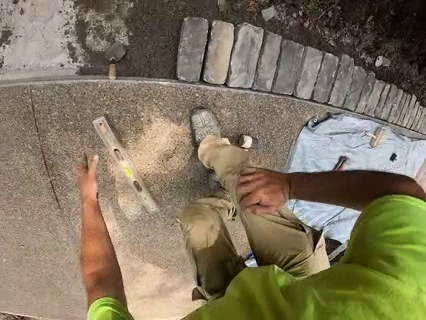

In [91]:
# given mp4 path, time in seconds, return frame in PIL
def get_frame(p_mp4: str, time: float):
    cap = cv2.VideoCapture(str(p_mp4))
    cap.set(cv2.CAP_PROP_POS_MSEC, time*1000)
    ret, frame = cap.read()
    return Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

def get_frames(p_mp4: str, times: list[float]):
    print(p_mp4.name, [round(t, 2) for t in times])
    cap = cv2.VideoCapture(str(p_mp4))
    frames = []
    duration_sec = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / cap.get(cv2.CAP_PROP_FPS)
    for time in times:
        if time > duration_sec:
            frame = Image.fromarray(np.random.randint(0, 255, (320, 320, 3), dtype=np.uint8))
        else:
            cap.set(cv2.CAP_PROP_POS_MSEC, time*1000)
            ret, frame = cap.read()
            frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frames.append(frame)
    print('done')
    return frames

p_mp4 = '/data/datasets/ego4d_data/v2/clips_320p-non_official/00030ae8-e5c4-41ec-a8ea-63548a7665d6.mp4'
frame = get_frame(p_mp4, 1)
frame

In [33]:
# bytes the var `frame` is holding
frame_bytes = frame.tobytes()
# size in bytes
frame_size = len(frame_bytes)
# size in MB
frame_size_MB = frame_size / 2**20
frame_size_MB

0.3900146484375

In [38]:
frame_size_MB * 4500 * 6 / 2**10  # GiB

10.283589363098145

In [ ]:
p_clips_dir = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official')

all_frames = []  # N x (1+5) x PIL Image
all_ious = []
for i, sample in enumerate(tqdm(data)):
    clip_uid = sample['clip_uid']
    query = sample['gt_window']['query']
    p_clip = p_clips_dir / f'{clip_uid}.mp4'
    t_gt = (sample['gt_window']['clip_start_sec'] + sample['gt_window']['clip_end_sec']) / 2
    ts = [t_gt]
    ious = []
    for s, e, iou in sample['pred_window']:
        t = (s + e) / 2
        ts.append(t)
        ious.append(iou)
    frames = get_frames(p_clip, ts)
    all_frames.append(frames)
    all_ious.append(ious)
    if i == 100:
        break

In [85]:
# memory usage of all_frames
all_frames_size = sum([len(frame.tobytes()) for frames in all_frames for frame in frames])
all_frames_size_MB = all_frames_size / 2**20
all_frames_size_MB

273.2391357421875

[0.0, 0.0, 0.6989450375962667, 0.0, 0.0]


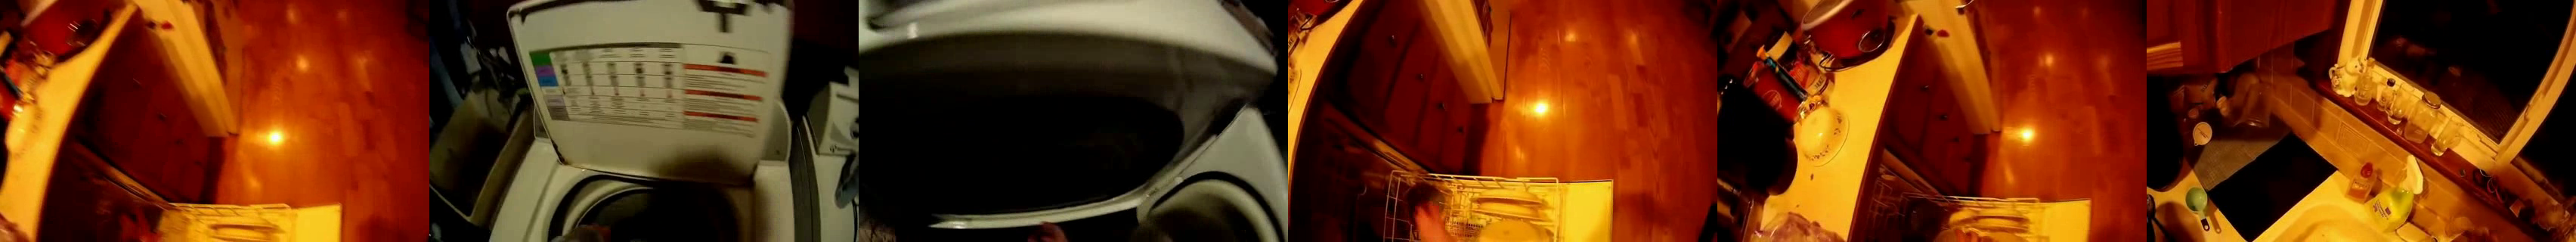

In [90]:
# concat PIL images horizontally
idx = 99
images = all_frames[idx]
print(all_ious[idx])

widths, heights = zip(*(i.size for i in images))
total_width = sum(widths)
max_height = max(heights)
new_im = Image.new('RGB', (total_width, max_height))
x_offset = 0
for im in images:
    new_im.paste(im, (x_offset, 0))
    x_offset += im.size[0]
new_im

# After creating

In [1]:
%cd /data/gunsbrother/prjs/ltvu/ours
from pathlib import Path
import torch
from sentence_transformers import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import cv2
from PIL import Image, ImageDraw, ImageFont

from ltvu.experiments.gvqa_visual_failure import get_frames

/data/gunsbrother/prjs/ltvu/ours


True

In [20]:
p_pt = 'results/gvqa_failure/clip-ViT-B-32/outputs.pt'
outputs = torch.load(p_pt)
np.set_printoptions(precision=4, suppress=True, linewidth=120)
len(outputs), outputs[0], outputs[0]['embs'].shape

(4552,
 {'clip_uid': 'cc2d7790-67f7-4e52-9fa9-33121c9431a2',
  'embs': array([[-0.1004,  0.3055,  0.0493, ...,  0.7233,  0.2583, -0.5646],
         [-0.307 , -0.2045,  0.056 , ...,  0.9473,  0.0666, -0.5317],
         [-0.1469,  0.1241,  0.2166, ...,  0.2924,  0.4824, -0.6732],
         [ 0.2149,  0.1632,  0.142 , ...,  0.403 ,  0.2955, -0.6889],
         [-0.1557, -0.3095, -0.0275, ...,  0.5396, -0.047 , -0.2875],
         [ 0.0436,  0.1388,  0.1261, ...,  0.7673,  0.2347, -0.1557]], dtype=float32),
  'hists': array([[0.412 , 0.0113, 0.    , 0.    , 0.0066, 0.0071, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
          0.    , 0.    , 0.    , 0.052 , 0.006 , 0.    , 0.    , 0.082 , 0.3389, 0.0089, 0.    , 0.    , 0.0051,
          0.0048, 0.    , 0.    , 0.    , 0.    , 0.    , 0.0009, 0.0001, 0.    , 0.    , 0.0149, 0.0546, 0.0099,
          0.    , 0.    , 0.0859, 0.7556, 0.0127, 0.    , 0.    , 0.0055, 0.0138, 0.    , 0.    , 0.    , 0.    ,
          0.    , 0.    , 0. 

In [22]:
idx = 1
assert outputs[idx]['exit_code'] == 0
embs = outputs[idx]['embs']
embs_gt, embs_pred = embs[0], embs[1:]
sims = outputs[idx]['sims']  # [1, k=5]
iou = outputs[idx]['ious']  # [k=5]
sims_hist = outputs[idx]['sims_hist']
sims, iou, sims_hist

(array([0.8187, 0.7957, 0.8597, 0.8067, 0.8385], dtype=float32),
 [0.22209382617533308, 0.0, 0.0, 0.0, 0.0],
 array([0.9328, 0.8454, 0.9875, 0.883 , 0.9283], dtype=float32))

In [66]:
def get_color_hist(frame):
    hist = cv2.calcHist([np.array(frame)], [0, 1, 2], None, [4, 4, 4], [0, 256, 0, 256, 0, 256])  # [4, 4, 4]
    hist = cv2.normalize(hist, hist).flatten()
    return hist

p_clip_dir = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official')
records = []
for output in outputs:
    if output['exit_code'] != 0:
        continue
    embs = output['embs']
    embs_gt, embs_pred = embs[0], embs[1:]
    sims = output['sims']  # [1, k=5]
    iou = np.array(output['ious'])  # [k=5]
    arg = np.argmax(iou)
    preds_ts = np.mean(output['preds'], axis=1).round(2).tolist()

    sims_hist = output['sims_hist']
    hists = output['hists']
    hists = hists / hists.sum(axis=1, keepdims=True)
    ces_hist = -np.sum(hists[:1] * np.log(hists[1:]+1e-6), axis=1)

    records.append({
        'clip_uid': output['clip_uid'],
        'sim': sims[arg],
        'sim_hist': sims_hist[arg],
        'ce_hist': ces_hist[arg],
        'iou': iou[arg],
        'gt_t': output['gt_t'],
        'pred_t': output['preds_t'],
        'query': output['query'],

        '_sim_min': sims.min(),
        '_sim_max': sims.max(),
        '_preds_ts': preds_ts,
        '_sims': sims,
        '_ces_hist': ces_hist,
        '_sims_hist': sims_hist,
        '_ious': iou,
    })
df = pd.DataFrame(records)
df.head()

clip_uid       sim  sim_hist   ce_hist  \
0  cc2d7790-67f7-4e52-9fa9-33121c9431a2  0.885639  0.998576  2.180851   
1  cc2d7790-67f7-4e52-9fa9-33121c9431a2  0.818740  0.932800  2.831549   
2  cc2d7790-67f7-4e52-9fa9-33121c9431a2  0.977469  0.999842  2.159624   
3  cc2d7790-67f7-4e52-9fa9-33121c9431a2  0.945480  0.983811  2.339051   
4  cc2d7790-67f7-4e52-9fa9-33121c9431a2  0.816556  0.933256  2.382493   

        iou        gt_t      pred_t  \
0  0.251845   28.808445  121.937950   
1  0.222094   79.152860   76.992065   
2  0.317008  103.352115  103.424187   
3  0.451612  136.675500  125.969437   
4  0.000000  192.125535  387.749985   

                                       query  _sim_min  _sim_max  \
0             Where did i put the fire gun ?  0.717136  0.885639   
1              Where was the drill machine ?  0.795747  0.859670   
2          Where did i put the screw driver?  0.802788  0.977469   
3   How many cables did I drop on the table?  0.879064  0.945480   
4  How many screw driver were on the table ?  0.744798  0.877251   

                                  _preds_ts  \
0       [121.94, 28.86, 6.13, 92.02, 58.52]   
1     [76.99, 463.1, 432.86, 404.06, 75.72]   
2  [103.42, 254.78, 204.86, 103.27, 388.96]   
3  [125.97, 137.18, 131.74, 126.65, 136.15]   
4     [387.75, 403.73, 8.95, 92.78, 392.32]   

                                               _sims  \
0  [0.7612587, 0.8856389, 0.84523267, 0.7171364, ...   
1  [0.81874037, 0.7957466, 0.8596699, 0.80674165,...   
2  [0.9774692, 0.9167384, 0.8443929, 0.9494681, 0...   
3  [0.927716, 0.9454796, 0.8834037, 0.8790636, 0....   
4  [0.816556, 0.8772511, 0.7447981, 0.8365714, 0....   

                                           _ces_hist  \
0  [3.0315392, 2.1808515, 2.6743069, 2.918796, 2....   
1  [2.8315487, 2.7657328, 2.3235989, 2.6019192, 2...   
2  [2.1596236, 2.254106, 2.3116522, 2.1562755, 2....   
3  [2.392447, 2.3390512, 2.435018, 2.385665, 2.39...   
4  [2.3824925, 2.394289, 2.4193542, 2.9047837, 2....   

                                          _sims_hist  \
0  [0.885807, 0.99857605, 0.94740975, 0.77187455,...   
1  [0.9328001, 0.84535277, 0.9874568, 0.88296276,...   
2  [0.9998424, 0.9777068, 0.94472975, 0.99934095,...   
3  [0.96759874, 0.9838112, 0.95599014, 0.97251904...   
4  [0.9332558, 0.9543288, 0.9597392, 0.7326025, 0...   

                                               _ious  
0          [0.0, 0.25184542965131346, 0.0, 0.0, 0.0]  
1          [0.22209382617533308, 0.0, 0.0, 0.0, 0.0]  
2  [0.3170081148225003, 0.0, 0.0, 0.2765778220149...  
3  [0.0, 0.4516117676797396, 0.0770968859209806, ...  
4                          [0.0, 0.0, 0.0, 0.0, 0.0]

In [56]:
# subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sim', y='iou', hue='clip_uid', legend=False, alpha=1, s=5, ax=axs[0])
sns.scatterplot(data=df, x='ce_hist', y='iou', hue='clip_uid', legend=False, alpha=1, s=5, ax=axs[1])
plt.show()

In [57]:
# heatmap of correlation, color range [-1, 1]
df_ = df[df.columns[1:6]].copy()
df_['d_pred_t'] = (df['pred_t'] - df['gt_t']).abs()
sns.heatmap(df_.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

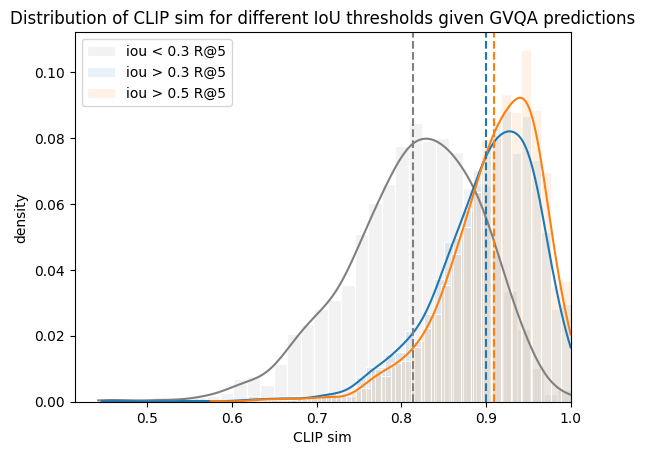

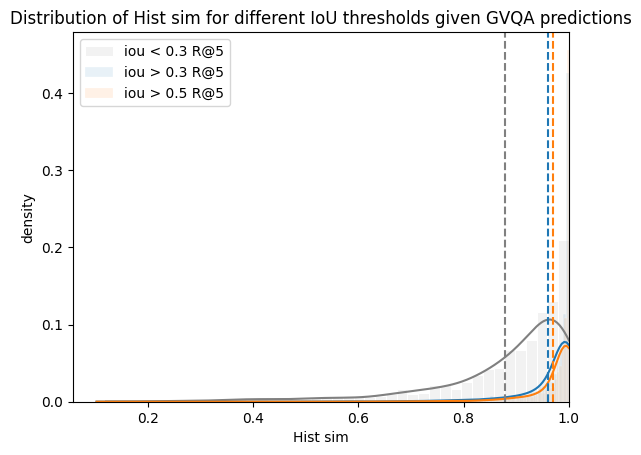

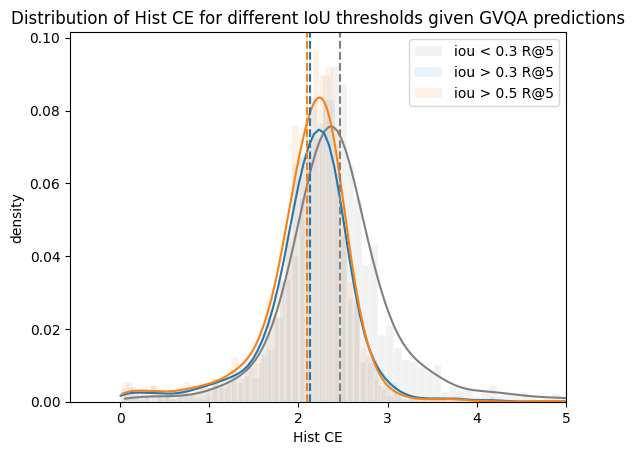

In [60]:
df_iou_lt_0_3 = df[df['iou'] < 0.3]
df_iou_gt_0_3 = df[df['iou'] > 0.3]
df_iou_gt_0_5 = df[df['iou'] > 0.5]

colors = sns.color_palette()
colors = ['gray', colors[0], colors[1]]

def draw(colname='sim', label='CLIP sim'):
    fig, ax = plt.subplots()
    hist_kws = dict(
        kde=True,
        ax=ax,
        stat='probability',
        ec='white',
        alpha=.1,
        kde_kws=dict(bw_adjust=1.2),
    )
    sns.histplot(df_iou_lt_0_3[colname], color=colors[0], label='iou < 0.3 R@5', **hist_kws)
    sns.histplot(df_iou_gt_0_3[colname], color=colors[1], label='iou > 0.3 R@5', **hist_kws)
    sns.histplot(df_iou_gt_0_5[colname], color=colors[2], label='iou > 0.5 R@5', **hist_kws)
    plt.axvline(x=df_iou_lt_0_3[colname].mean(), color=colors[0], linestyle='--')
    plt.axvline(x=df_iou_gt_0_3[colname].mean(), color=colors[1], linestyle='--')
    plt.axvline(x=df_iou_gt_0_5[colname].mean(), color=colors[2], linestyle='--')
    ax.set_xlabel(label)
    ax.set_ylabel('density')
    plt.xlim(right=min(df[colname].max(), 5))
    ax.set_title(f'Distribution of {label} for different IoU thresholds given GVQA predictions')
    ax.legend()
    plt.show()
draw('sim', 'CLIP sim')
draw('sim_hist', 'Hist sim')
draw('ce_hist', 'Hist CE')

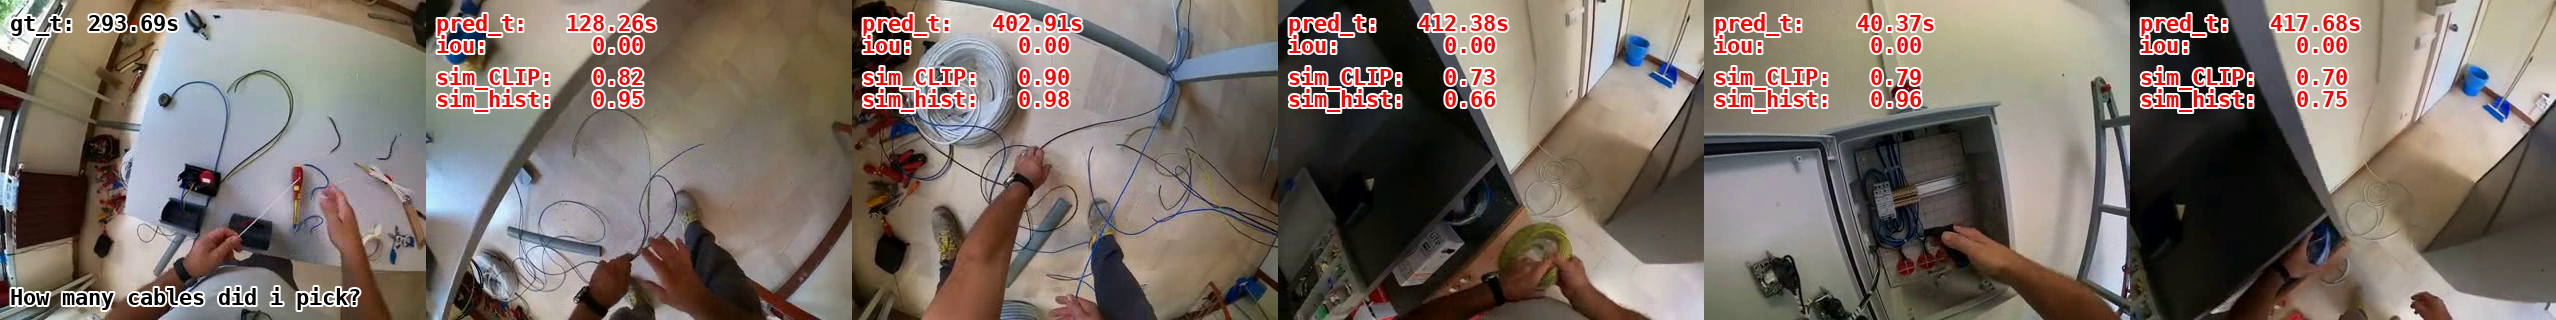

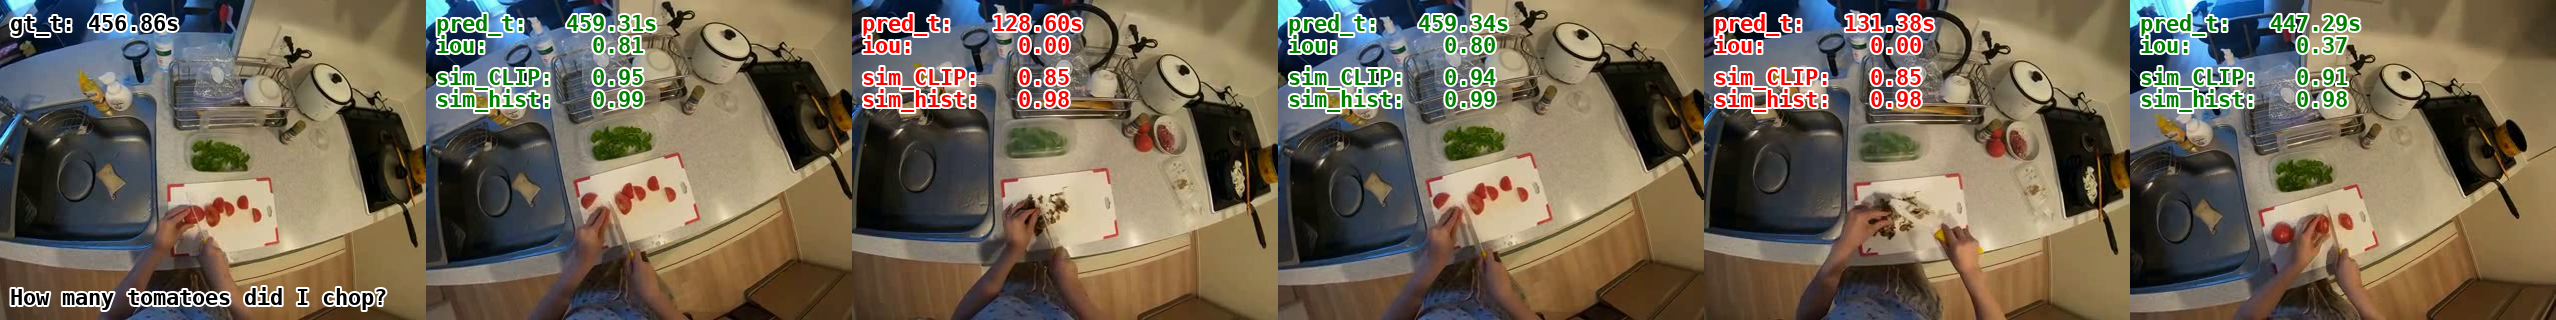

In [70]:
from IPython.display import display

def patch_horizontally(images: list[Image.Image]):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    return new_im

def visualize(
    clip_uid: str, gt_t: float, preds_ts: list[float],
    query: str, ious, sims, sims_hist=None
):
    p_clip_dir = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official')
    p_clip = p_clip_dir / f"{clip_uid}.mp4"

    # read frames
    preds_ts = preds_ts.tolist() if isinstance(preds_ts, (torch.Tensor, np.ndarray)) else preds_ts
    ret, frames = get_frames(p_clip, [gt_t] + preds_ts)

    # annotate timestamp, iou, sim as texts on each image
    font_size, path_font = 22, '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf'
    font = ImageFont.truetype(path_font, font_size)
    text_kws = dict(font=font, stroke_width=2, stroke_fill='white')
    gt_frame, pred_frames = frames[0], frames[1:]
    gt_draw = ImageDraw.Draw(gt_frame)
    gt_draw.text((10, 10), f"gt_t: {gt_t:.2f}s", fill='black', **text_kws)
    gt_draw.text((10, gt_frame.size[1]-10), query, fill='black', anchor='lb', **text_kws)
    for i, (frame, pred_t, iou, sim, sim_hist) in enumerate(zip(pred_frames, preds_ts, ious, sims, sims_hist)):
        # sim_hist = hists[0] @ hists[i+1]
        draw = ImageDraw.Draw(frame)
        fill = 'red' if iou < 0.3 else 'green'
        draw.text((10, 10),             f"pred_t:   {pred_t:6.2f}s", fill=fill, **text_kws)
        draw.text((10, 10+font_size),   f"iou:      {iou:6.2f}", fill=fill, **text_kws)
        draw.text((10, 20+2*font_size), f"sim_CLIP: {sim:6.2f}", fill=fill, **text_kws)
        draw.text((10, 20+3*font_size), f"sim_hist: {sim_hist:6.2f}", fill=fill, **text_kws)
    return patch_horizontally([gt_frame] + pred_frames)

idx = 9
sample = df[df['iou']<.3].iloc[idx]
display(visualize(sample['clip_uid'], sample['gt_t'], sample['_preds_ts'], sample['query'], sample['_ious'], sample['_sims'], sample['_sims_hist']))
sample = df[df['iou']>.8].iloc[idx]
display(visualize(sample['clip_uid'], sample['gt_t'], sample['_preds_ts'], sample['query'], sample['_ious'], sample['_sims'], sample['_sims_hist']))

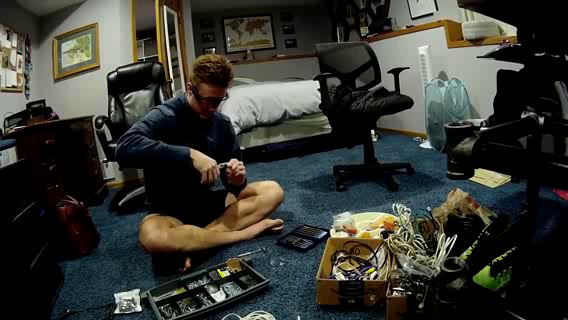

array([0.9698, 0.0423, 0.    , 0.    , 0.0068, 0.071 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0279, 0.0005, 0.    , 0.    , 0.0564, 0.1399, 0.0007, 0.    , 0.0006, 0.0067, 0.0044, 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.0002, 0.    , 0.    , 0.    , 0.0122, 0.0171, 0.0001, 0.    , 0.0015, 0.0391,
       0.1608, 0.0002, 0.0001, 0.0001, 0.01  , 0.0011, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0002, 0.0036, 0.0061, 0.    , 0.0001, 0.0006, 0.0198, 0.024 ], dtype=float32)

In [39]:
frame = get_frames()[1][0]
display(frame)
get_color_hist(frame)